## 학교 전력 데이터를 이용하여 net load 선형 예측해보기 - 2. 단순선형회귀모델 찾기

### 목표: Day N의 net load data를 알 때 Day N+1의 net load를 예측하는 선형 회귀 모델을 만드는 것이 목표이다.


### 데이터 종류: PV 데이터, net load 데이터


### 데이터 가공: 일단 pv 데이터는 이용하지 않고, net load 데이터들만 쭉 모아서 단순선형회귀모델을 만들어본다.


### 프로세스
1. 데이터 가공
  - 전력사용량 데이터(net load) excel에서 신재생에너지동(RISE) 데이터만 쭉 뽑기
  - 신재생에너지동(E)도 고려
  - 반복문을 사용하여 엑셀에서 column을 쭉 뽑음
  - 셀이 '-'로 채워진 데이터는 누락시킴. 이 경우 일단 Day N, N+1 관계 성립 안 됨
  - 평일&비공휴일/주말|공휴일 구분하여 서로 다른 csv 파일에 저장(week/weekend): 주말 및 공휴일의 flag를 1로 설정한 2021 calendar excel 파일 제작하여 이용

2. 선형회귀모델 찾기
*   torch.linalg.pinv 이용하여 pseudo-inverse matrix(선형 변환 matrix) 구하기
*   sklearn의 LinearRegression 모듈을 이용하여 Linear Regression model 구하기
*   경사하강법을 이용하여 Linear Regression model 찾기
 - learning rate: 1e-6
 - epoch: 5000
 - train:test = 8:2


### 보완점
다중선형회귀모델을 만들어볼 수 있을 것. PV data, 외기온도, 비상전력데이터, 주말 여부(flag 등으로 처리) 등을 고려할 수 있음.
노이즈를 추가할 수 있음.
누락된 값을 고려하여 더 정확하게 측정할 수 있음.

==> 피드백 받은 부분:
1. 월요일부터 금요일까지의 주중 데이터만 이용해보기. calender file만 따로 만들어서 휴일에는 flag를 마크하여 data와 calender 비교해서 처리하기!
2. output이랑 y plot 해서 비교해보기! mse가 크게 나온 것은 rmse로 하면 60 정도, 전력 데이터양에 따라 달라지는 것이기 때문에 그리 정확하지 않음. 보통 평균적으로 얼만큼 전력을 쓰는지도 함께 기입하여 비교함! mse, mae, mape 등의 지표를 사용하는 것도 좋음. mape의 경우 평균치에 비해(%) 얼마나 오차가 발생했는지를 보여주기 때문에 비교하기 좋음.
3. 누락된 데이터의 경우에는 interpollation 실행. 대표적인 방법으로는 (1)전날과 다음날의 평균을 취한다. (2)전날 데이터를 그대로 가져온다. (3)전날과 가장 값이 비슷한 이전 데이터를 찾아서 그 다음날의 데이터를 취한다...


==> 보완된 부분
1. 많은 데이터를 가공하기 위해 format을 이용하여 file_path를 지정하였다.
2. Emergency data를 포함하였다.
3. 가공한 데이터를 csv 형식으로 저장해두었다.


In [ ]:
# load refined data

# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import torch
import os

df = pd.read_csv('/content/drive/MyDrive/week_2021_netload.csv', index_col=0)

X = df.iloc[0:236,:]
Y = df.iloc[1:237,:]

Mounted at /content/drive


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
210104,879.6,906.7,902.6,866.7,821.9,869.8,853.7,893.9,1063.9,1099.7,...,1103.2,1099.1,1105.6,1100.7,1043.8,1016.0,975.6,979.7,982.6,933.4
210105,925.6,936.7,882.7,894.6,864.2,859.1,853.7,891.3,957.4,1084.6,...,1159.4,1173.3,1168.5,1149.9,1105.5,976.7,978.8,989.3,965.6,968.6
210106,941.6,938.5,908.3,922.8,889.1,909.2,890.2,958.8,1094.0,1174.3,...,1108.5,1095.2,1121.3,1150.4,1040.5,1043.8,1018.8,1017.6,978.0,958.3
210107,959.1,993.6,928.9,974.8,1028.6,985.0,971.7,1021.1,1077.4,1265.7,...,1350.3,1351.6,1358.4,1349.0,1279.1,1213.7,1264.2,1229.0,1223.8,1205.3
210108,1190.3,1182.8,1160.8,1122.6,1099.7,1116.8,1140.9,1152.3,1314.6,1387.3,...,1342.3,1312.9,1317.2,1345.6,1326.0,1207.8,1231.6,1258.3,1264.5,1202.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211224,782.2,793.3,787.0,756.0,771.0,761.1,770.9,812.5,886.9,995.8,...,927.1,898.5,918.8,941.3,836.4,856.5,783.0,807.5,819.0,787.2
211227,862.1,868.6,836.0,849.5,886.9,861.9,888.2,896.7,1085.6,1175.6,...,1127.3,1143.3,1149.3,1139.0,1111.6,1011.1,1026.3,946.0,938.4,922.8
211228,885.6,890.9,859.7,875.7,868.3,853.8,850.5,868.5,958.5,1124.9,...,1134.4,1102.5,1071.2,1091.4,997.6,928.1,933.0,862.6,902.8,896.1
211229,847.5,877.3,824.7,813.5,836.8,774.4,809.9,853.0,976.3,1021.6,...,959.4,976.4,998.9,956.7,893.3,871.3,902.9,878.8,910.0,869.2


In [ ]:
from torch import linalg as LA
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.8, shuffle=False)

# LA expects tensor, so change dataframe to numpy to tensor
# In this process, I changed numpy type from object to float64 because 'from_numpy' method cannot convert object type
x_train_tnsr = torch.from_numpy(x_train.values.astype(np.float64))
y_train_tnsr = torch.from_numpy(y_train.values.astype(np.float64))

# getting pseudo-inverse with pinv method
x_pinv = LA.pinv(x_train_tnsr)
a = torch.matmul(x_pinv, y_train_tnsr)
a.shape

torch.Size([24, 24])

In [ ]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
211020,680.8,697.4,663.2,687.8,645.1,621.0,654.7,650.4,653.4,843.3,...,821.4,816.1,844.6,836.6,769.7,767.1,744.0,717.5,718.4,700.1
211021,721.3,693.5,661.8,692.7,678.6,686.2,658.9,674.7,711.7,772.3,...,735.3,753.2,728.1,778.0,738.2,685.2,682.7,678.3,686.9,665.0
211022,667.0,644.4,627.2,646.5,608.5,609.6,609.1,624.9,688.7,731.3,...,721.1,728.4,737.4,706.8,678.4,640.2,621.7,666.1,614.3,602.3
211025,622.6,613.1,603.1,591.0,616.6,578.1,586.8,626.4,636.7,724.5,...,757.8,743.7,750.0,735.2,723.7,694.9,708.7,699.9,681.9,669.5
211026,693.4,653.1,635.8,609.0,613.2,587.6,594.0,590.6,686.8,744.4,...,748.0,735.2,785.3,741.6,726.9,700.2,682.3,688.1,698.0,665.8
211027,655.1,656.5,654.8,631.0,617.7,628.2,649.1,603.2,673.9,716.4,...,735.9,752.5,736.7,746.5,719.7,687.1,704.1,703.6,713.1,679.4
211028,687.3,641.2,649.4,626.5,615.0,628.9,579.0,642.5,709.5,761.5,...,763.1,765.1,788.4,782.7,707.7,661.3,687.7,667.5,671.6,657.0
211101,642.4,644.2,637.7,622.8,604.9,596.1,620.9,628.0,723.5,734.5,...,765.4,790.6,778.6,775.0,723.1,746.1,713.6,708.0,717.0,704.3
211102,656.0,670.0,655.0,643.9,605.5,623.7,613.2,619.7,708.7,786.5,...,773.4,804.1,812.1,804.0,760.8,735.2,702.1,705.1,667.4,689.3
211103,680.9,689.7,642.6,625.6,638.0,627.5,633.9,641.6,692.1,751.9,...,726.5,754.3,750.2,733.7,692.8,667.4,735.5,725.0,695.8,711.4


In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
210104,879.6,906.7,902.6,866.7,821.9,869.8,853.7,893.9,1063.9,1099.7,...,1103.2,1099.1,1105.6,1100.7,1043.8,1016.0,975.6,979.7,982.6,933.4
210105,925.6,936.7,882.7,894.6,864.2,859.1,853.7,891.3,957.4,1084.6,...,1159.4,1173.3,1168.5,1149.9,1105.5,976.7,978.8,989.3,965.6,968.6
210106,941.6,938.5,908.3,922.8,889.1,909.2,890.2,958.8,1094.0,1174.3,...,1108.5,1095.2,1121.3,1150.4,1040.5,1043.8,1018.8,1017.6,978.0,958.3
210107,959.1,993.6,928.9,974.8,1028.6,985.0,971.7,1021.1,1077.4,1265.7,...,1350.3,1351.6,1358.4,1349.0,1279.1,1213.7,1264.2,1229.0,1223.8,1205.3
210108,1190.3,1182.8,1160.8,1122.6,1099.7,1116.8,1140.9,1152.3,1314.6,1387.3,...,1342.3,1312.9,1317.2,1345.6,1326.0,1207.8,1231.6,1258.3,1264.5,1202.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211013,790.1,776.3,774.6,727.3,749.1,710.8,707.0,747.2,806.7,880.4,...,973.0,1011.0,999.5,1002.5,949.4,923.9,897.4,879.7,859.6,825.9
211014,801.7,804.5,763.2,769.7,743.0,752.2,768.4,771.8,823.8,912.8,...,1034.7,1066.7,1051.7,1052.1,948.6,920.1,868.4,887.9,823.7,837.6
211015,810.5,791.0,757.9,748.4,730.4,751.4,727.2,726.6,798.9,885.8,...,964.1,995.9,986.9,971.6,889.5,814.9,836.1,812.0,787.0,776.7
211018,576.7,575.6,573.1,565.6,558.2,554.8,556.0,565.1,587.6,650.0,...,820.2,855.5,851.4,840.6,813.6,753.7,773.5,762.8,767.2,756.7


In [ ]:
y_test

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
211021,721.3,693.5,661.8,692.7,678.6,686.2,658.9,674.7,711.7,772.3,...,735.3,753.2,728.1,778.0,738.2,685.2,682.7,678.3,686.9,665.0
211022,667.0,644.4,627.2,646.5,608.5,609.6,609.1,624.9,688.7,731.3,...,721.1,728.4,737.4,706.8,678.4,640.2,621.7,666.1,614.3,602.3
211025,622.6,613.1,603.1,591.0,616.6,578.1,586.8,626.4,636.7,724.5,...,757.8,743.7,750.0,735.2,723.7,694.9,708.7,699.9,681.9,669.5
211026,693.4,653.1,635.8,609.0,613.2,587.6,594.0,590.6,686.8,744.4,...,748.0,735.2,785.3,741.6,726.9,700.2,682.3,688.1,698.0,665.8
211027,655.1,656.5,654.8,631.0,617.7,628.2,649.1,603.2,673.9,716.4,...,735.9,752.5,736.7,746.5,719.7,687.1,704.1,703.6,713.1,679.4
211028,687.3,641.2,649.4,626.5,615.0,628.9,579.0,642.5,709.5,761.5,...,763.1,765.1,788.4,782.7,707.7,661.3,687.7,667.5,671.6,657.0
211101,642.4,644.2,637.7,622.8,604.9,596.1,620.9,628.0,723.5,734.5,...,765.4,790.6,778.6,775.0,723.1,746.1,713.6,708.0,717.0,704.3
211102,656.0,670.0,655.0,643.9,605.5,623.7,613.2,619.7,708.7,786.5,...,773.4,804.1,812.1,804.0,760.8,735.2,702.1,705.1,667.4,689.3
211103,680.9,689.7,642.6,625.6,638.0,627.5,633.9,641.6,692.1,751.9,...,726.5,754.3,750.2,733.7,692.8,667.4,735.5,725.0,695.8,711.4
211104,650.6,644.9,620.6,638.9,642.2,591.7,598.3,615.5,705.0,778.3,...,785.4,775.6,797.8,807.5,734.5,718.4,720.6,725.8,733.2,702.6


In [ ]:
y_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
210105,925.6,936.7,882.7,894.6,864.2,859.1,853.7,891.3,957.4,1084.6,...,1159.4,1173.3,1168.5,1149.9,1105.5,976.7,978.8,989.3,965.6,968.6
210106,941.6,938.5,908.3,922.8,889.1,909.2,890.2,958.8,1094.0,1174.3,...,1108.5,1095.2,1121.3,1150.4,1040.5,1043.8,1018.8,1017.6,978.0,958.3
210107,959.1,993.6,928.9,974.8,1028.6,985.0,971.7,1021.1,1077.4,1265.7,...,1350.3,1351.6,1358.4,1349.0,1279.1,1213.7,1264.2,1229.0,1223.8,1205.3
210108,1190.3,1182.8,1160.8,1122.6,1099.7,1116.8,1140.9,1152.3,1314.6,1387.3,...,1342.3,1312.9,1317.2,1345.6,1326.0,1207.8,1231.6,1258.3,1264.5,1202.8
210111,1071.3,1016.5,1006.8,990.2,1030.1,1014.6,1000.6,1076.4,1123.6,1278.8,...,1246.7,1268.7,1247.8,1256.7,1208.7,1144.6,1192.8,1164.9,1137.9,1139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211014,801.7,804.5,763.2,769.7,743.0,752.2,768.4,771.8,823.8,912.8,...,1034.7,1066.7,1051.7,1052.1,948.6,920.1,868.4,887.9,823.7,837.6
211015,810.5,791.0,757.9,748.4,730.4,751.4,727.2,726.6,798.9,885.8,...,964.1,995.9,986.9,971.6,889.5,814.9,836.1,812.0,787.0,776.7
211018,576.7,575.6,573.1,565.6,558.2,554.8,556.0,565.1,587.6,650.0,...,820.2,855.5,851.4,840.6,813.6,753.7,773.5,762.8,767.2,756.7
211019,700.8,702.5,683.4,696.7,668.9,665.0,656.7,659.5,702.7,780.3,...,870.4,911.9,875.6,843.3,769.0,763.5,736.9,769.0,723.6,712.9


In [ ]:
# evaluation
import torch.nn as nn

# use MSE as loss function
# loss를 줄여나가는 것은 아니고(학습을 시키는 것은 아니므로) test set에 대해 loss를 측정해봄으로써 a의 정확도 분석
loss_func = nn.MSELoss()


x_test_tnsr = torch.from_numpy(x_test.values.astype(np.float64))
y_test_tnsr = torch.from_numpy(y_test.values.astype(np.float64))

output = torch.matmul(x_test_tnsr, a)
loss = loss_func(output, y_test_tnsr)

print('rmse:',loss**(0.5))

rmse: tensor(58.9135, dtype=torch.float64)


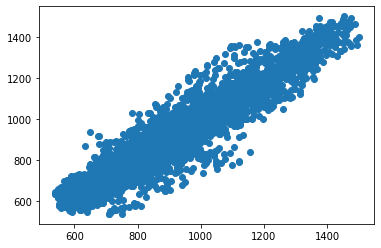

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x_train_tnsr.detach().numpy(), y_train_tnsr.detach().numpy())

plt.show()

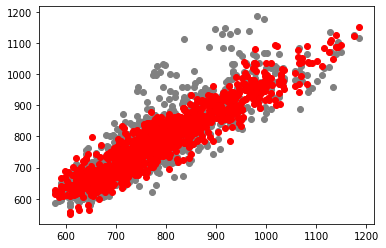

In [ ]:
plt.scatter(x_test_tnsr.detach().numpy(),y_test_tnsr.detach().numpy(), c="gray")
plt.scatter(x_test_tnsr.detach().numpy(),output.detach().numpy(), c="red")

plt.show()

In [ ]:
# 모델 평가를 위해 r2 score 사용

from sklearn.metrics import r2_score

sk_r2 = r2_score(y_test, output)
print('r2 score:', sk_r2)


r2 score: 0.6110223654311029
